# Chapter 3: Impacts of Decision Making on Agricultural Outcomes

[⬅️ Previous Chapter](Chapter%202.ipynb)

![](../assets/farm_02.png)

## Chapter Objectives

* Understand the tradeoffs between yield, climate, and crop phenology.
* Learn to use functions to expedite repetative analysis 
* Develop a very simple ecohydrological model of soil water availability
* Explore how rainfall seasonality affects the dynamics of soil water availability in annual crop systems
* Learn how to run ensembles of simulations and aggregate output
* Examine how planting date and crop choice alter average soil moisture during the growing season

## Laikipia Climate

As we've seen, the climate of northern Kenya is marked by pronounced rainfall variability. In addition, there is very little variation in temperature and solar radiation. The graphs below provide long-term monthly patterns of both temperature and rainfall, which emphasize the dominat role that temporal variation in rainfall plays in governing the climate of this system.

<table>
    <tr>
        <td>![](../assets/nanyuki_rainfall.png)</td><td>![](../assets/nanyuki_temperature.png)</td>
    </tr>
</table>


## Climate variability and decision making

Given the variation in rainfall both within and between years, it is reasonable to wonder what timing of planting is optimal for ensuring the success of maize, which is the main crop in this region. In addition, farmers must make decisions about what variety of maize to plant. 

### Crop Choice

Decisions about what type of maize to plant break down along two axes: Early harvesting varieties vs. Late harvest varieties, and Local varieties vs. Hybrid varieties. 

Recently, hybrid varieties designed specifically for the dry conditions of many Kenyan agricultural zones have started to become available. For example, here's a [report](https://basis.ucdavis.edu/news/one-change-hybrid-seeds-could-boost-maize-productivity-western-kenya) based on work at UC Davis on development of Kenya-specific hybrid maize varieties that shows great promise. That being said, hybrid varieties require farmers to purchase seeds annually, rather than saving seeds from the prior year's harvest which creates a cost burden on smallholder farmers. While it is likely that - just as in US agriculture - hybrid and even GMO varieties of maize will come to dominate Kenyan agrticulture in the coming decades, household farms will remain dependent on local seeds. Regardless, the interaction between economic and agronomic tradeoffs is too complex for our excercise, so we will focus on the first decision - choosing between fast-maturing varieties that produce lower yields vs. slower-maturing varities that have higher yields.

We can investigate the relationship between `yield` and `days to maturity` using some data on hybrid maize varieties used in Kenya. Eventhough we will be focusing on local maize varieties which have lower yields overall than any hybrid variety, we can assume any relationship seen between `yield` and `days to maturity` in hybrid maize is similar for local maize.

## Getting started

As usual, we need to load pands, our plotting libraries, and remind jupyter to render our plots into our notebooks.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
hybrid_data = pd.read_csv('../data/hybrid_yields.csv')
hybrid_data

,Unnamed: 0,VARIETY,ALTITUDE RANGE (M),yield (kg/ha),days_to_maturity
0,0,H6213,1700-2100,4680.0,175.0
1,1,H6212,1700-2100,4680.0,175.0
2,2,H6210,1700-2100,4500.0,175.0
3,3,H9401,1700-2100,4320.0,175.0
4,4,H629,1700-2400,4320.0,175.0
5,5,H628,1500-2100,4140.0,165.0
6,6,H627,1500-2100,3960.0,165.0
7,7,H626,1500-2100,3780.0,165.0
8,8,H625,1500-2100,3600.0,165.0
9,9,H614,1500-2100,3420.0,175.0


We have 23 different hybrid varieties, with data on the _maximum_ `yield (kg/ha)` and `days_to_maturity` for each variety. Let's see if there's a relationship between these two variables:

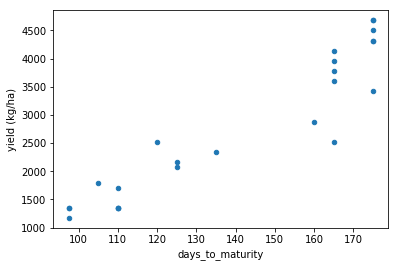

In [3]:
hybrid_data.plot.scatter(x='days_to_maturity', y='yield (kg/ha)')

That's a pretty clear linear relationship, which isn't totally unexpected; it stands to reason that annual crops that grow for a longer period will also yield more at harvest time.

<div class="alert alert-success">✏️ <strong>DIY Code:</strong> Use the tools and functions from <code>Chapter 2</code>'s curve-fitting excercise to determine the best-fit linear relationship between these data and the $r^2$ value.</div>

In [4]:
# This cell intentionally left blank [OPTIONAL]

### Planting Date

Farmers have to choose planting dates in anticipation of there being adequate rainfall during the subsequent growing period to avoid crop failure. Despite the promising data in the figure above, which shows _optimal_ yields from hybrid varities of up to 4.5 tons/ha, actual yields of maize in Kenya are around 1.4-1.6 tons/ha. That number - while 50% higher than it was only a decade ago - is about 1/3 of the yields seen in the US Midwest. So even in the absence of crop failure, success has a lower bound than elsewhere. 

## Tradoffs between yield, planting date, and crop failure

The remainder of this Chapter will be focused on developing a simple model that captures the dynamics implicit in the discussion above:

1. Higher yield varieties of maize require longer periods of growth
2. Longer periods of growth increase the potention for exposure of crops to prolonged drought.
3. Prolonged drought increases the probability of crop failure
4. The timing of planting determines how these tradeoffs will play out.

Let's take each of these topics in order:

### 1. Tradeoffs between yield and days to maturity

Just in case you didn't actually calculate the regression line between `yield (kg/ha)` and `days_to_maturity` 😉, we can eyeball the figure, and estimate the slope of the line to be about `40:1`, so that each additional day of maturity increases yield by 40 kg/ha.

### 2. Tradoffs between days to maturity and exposure to climate variability

This tradeoff is harder to quantify. Instead, we will model the interaction between days to maturity and crop failure. Our strategy will be to examine a very field-scale water balance that looks only at relative water availability \[mm/mm\], $s$, daily rainfall, $R$ \[mm/day\], and daily water demand, which we will characterize as reference evapotranspiration, $ET_0$ \[mm/day\]. Because temperature is relatively constant, we will assume that $ET_0$ is constant. Therefore our water balance is simply:


$$ \frac{dS}{dt} = R(t) - ET_0 $$

This formulation ignores many important processes related to soil water storage and plant response to drought. As defined, it is essentially a cumulative dryness index; during periods of the season when $\sum_t R(t) > t \times ET_0$, there will accumulation of water in the soil. During periods when $\sum_t R(t) < t \times ET_0$, the soil will dry out. 

Because the amount of plant available water in the soil in bounded between zero and some maximum, we add an additional parameter, $S_{max}$, which is the maximum amount of water `[mm]` that can be stored in the root zone. Now our model looks like this:

$$
\begin{eqnarray}
    \frac{dS}{dt} &=& R(t) - ET_0 & if & (0 \leq S \leq S_{max}) \\
    & & & else; \\
    \frac{dS}{dt} &=& 0 
\end{eqnarray}       
$$

Assuming a typical value of porosity is 0.4 and soil depth is 500 mm (0.5 meters), the value of $S_{max}$ is 200, here is what our model looks like in python:

```python
n = 0.4  # Porosity, [m3/m3]
Zr = 500 # Rooting depth [mm]
S_max = n*Zr    # Max soil water storage [mm]
S[0] = 30  # Initial soil water storage [mm]
ET_0 = 6.5 # Daily reference evapotranspiration [mm]

S = np.zeros(len(R)) # Pre-allocate the array for S
dSdt = np.zeros(len(R))# Pre-allocate the array for dSdt

for t in range(len(R)):
    dSdt[t] = R[t] - ET_0
    S[t+1] = S[t] + dSdt[t]
    if S[t+1] < S_max:
        S[t+1] = S_max
    if S[t+1] < 0:
        S[t+1] = 0
```

However, before implementing the model, we need to organize our rainfall simulation code so it is easier to work with.


I've created a few functions that will speed up our analysis.

#### ▶️ read_data()

<div class="alert alert-info">This function will read in our CETRAD data file and returns a cleaned up version using the methods we developed in <code>Chapter 2</code>. </div>

In [5]:
def read_data():
    from dateutil.relativedelta import relativedelta
    # Read in the raw csv data.
    df = pd.read_csv("../data/CETRAD_rainfall.csv")

    # Step 1. Convert text strings into datetime objects.
    format = '%m/%d/%y'  # Column RDate has data in M/D/YY
    df['Datetime'] = pd.to_datetime(df['RDate'], format=format)  # Create a new column of datetime objects using RDate.  # NOQA

    # 2. Step 2. Convert future dates inferred during the conversion back into
    # 20th century dates. Python is a future-looking programming language, and
    # assumes that 1/1/34 is Jan 1, 2034. We fix this by finding all the dates
    # in the future (dt > datetime.now()) and removing 100 years from
    # their value. This requires using a relativedelta function, which handles
    # weird stuff like leap years.
    df['Datetime'] = df['Datetime'].map(
        lambda dt: dt+relativedelta(years=-100) if dt > datetime.now() else dt)

    # Step 3. Extract the Year and Month from the Datetime to make
    # aggregation easier.
    df['Year'] = [dt.year for dt in df['Datetime']]
    df['Month'] = [dt.month for dt in df['Datetime']]

    # Step 4. Use the Datetime values as the index for this dataframe.
    df = df.set_index(pd.DatetimeIndex(df['Datetime']))  # Set the Datetime column as the dataframe index # NOQA

    # Step 5.  Delete the old RDate column, which we no longer need.
    # We will keep the Datetime column, in case we need it later.
    df = df.drop(['RDate'], axis=1)

    return df

#### ▶️ analyze_rainfall()

<div class="alert alert-info"> This function will analyze a specific station and returns the raw data, as well as $\alpha$ and $\lambda_r$ values for each month. If <code>start_date</code> or <code>end_date</code> are passed, then they are used to subset the data to specific years. Otherwise, the entire dataset is returned.</div>

In [6]:
def analyze_rainfall(station='JACOBSON FARM', start_year=None, end_year=None):
    rainfall_data = read_data()
    data = rainfall_data[[station, 'Month', 'Year', 'Datetime']]
    if not start_year:
        start_year = min(data['Year'])
    if not end_year:
        end_year = max(data['Year'])
    if start_year < min(data['Year']):
        start_year = min(data['Year'])
    if end_year > max(data['Year']):
        end_year = max(data['Year'])
    data = data.loc[(data['Year'] >= start_year) & (data['Year'] <= end_year)]

    # First, find all the rows in the data where it rained and group by month.
    rain_days = data.loc[data[station] > 0]

    # Find all locations in the data where an observation was made.
    all_days = data.loc[data[station] >= 0]

    lambda_by_month = (
        rain_days.groupby('Month')[station].count() /
        all_days.groupby('Month')[station].count()
    )

    alpha = rain_days[station].mean()

    return alpha, lambda_by_month, data

#### ▶️ seasonal_lambdas()

<div class="alert alert-info">Generates $\lambda_r$ values for each day in a growing season given a planting_date and an array of 12 $\lambda_r$ values (<code>lambda_by_month</code>).</div>

In [7]:
from datetime import datetime, timedelta
def seasonal_lambdas(lambda_by_month, planting_date=datetime.now(), days_to_maturity=150):
    """ Generates daily values of lambda_r for a growing season. 
    
    Usage: seasonal_lambdas(lambda_by_month, planting_date=datetime.now(), days_to_maturity=150)
    
    Arguments:
        lambdas_by_month: an array of 12 values of lambda_r, one for each month.
        planting_date: The datetime of planting. Default is today.
        days_to_maturity: The length of the growing season
    """
    start_date = planting_date
    end_date = planting_date + timedelta(days=days_to_maturity)
    datetimes = np.arange(
        start_date, end_date, timedelta(days=1)).astype(datetime)
    month_value_by_day = np.array([datetime.month for datetime in datetimes])
    lambda_values = np.array([lambda_by_month[i] for i in month_value_by_day])
    return lambda_values, datetimes


#### ▶️ simulate_rainfall()

<div class="alert alert-info">Generates a simulation of a season of rainfall. Uses a planting date (which must be passed as a <code>DateTime</code> object, as well as a lenght of the growing season (<code>days_to_maturity</code>), which have default values of <code>now()</code> and <code>150</code>, respectively. Requires passing in an array of 12 $\lambda_r$ values (<code>lambda_by_month</code>), and a single value of $\alpha$ (<code>alpha</code>). Returns a time series of daily rainfall in mm (<code>simulated rainfall</code>).</div>

In [8]:
def simulate_rainfall(lambda_by_month, alpha, planting_date=datetime.now(), days_to_maturity=150, n_seasons=1):
    """ Simulates a season of rainfall.

    Usage:

    simulate_rainfall(
        planting_date=datetime, days_to_maturity,
        lambda_values, alpha_values
    )

    Arguments:
        - planting_date = datetime object specifying month/day of planting.
        - days_to_maturity - integer number of days until crop is mature
        - lambda_values - array of 12 lambda values; one for each month
        - alpha value - a constant average storm depth

    """
    lambda_values, datetimes = seasonal_lambdas(lambda_by_month, planting_date, days_to_maturity)
    size = [n_seasons, len(lambda_values)]
    simulated_rainy_days = (np.random.uniform(
        low=0, high=1, size=size) <= lambda_values).astype(int)
    simulated_rainfall_values = np.random.exponential(scale=alpha, size=size)
    simulated_rainfall = simulated_rainy_days * simulated_rainfall_values
    return simulated_rainfall.squeeze(), datetimes
    # df =  pd.DataFrame(simulated_rainfall).transpose()
    # return df

#### ▶️ Running the rainfall model

We can run the entire rainfall model using this sequence of commands:

```python
    alpha, lambda_by_month, data = analyze_rainfall(station='JACOBSON FARM')
    R = simulate_rainfall(lambda_by_month, alpha)
```

<div class="alert alert-success">✏️ <strong>DIY Code:</strong> Use the model functions to generate rainfall for 30 years for the station <code>RUMURUTI (NRM)</code>.</div>

In [9]:
# This cell intentionally left blank

In [10]:
alpha, lambda_by_month, data = analyze_rainfall(station='JACOBSON FARM')
R, dt = simulate_rainfall(lambda_by_month, alpha, planting_date=datetime(year=2018,month=12,day=1))

## Coding up the ecohydrological model

Now that we have a 2-line method for generating rainfall, let's implement our model. Here's the code from above, ready to run.

In [11]:
def run_model(R,Zr=500,ET_0=3.5,S_0=30,n=0.4,):
    """ Runs a simple model with constant ET_o. 
    
    Usage: run_model(R,Zr=500,ET_0=6.5,S_0=30,n=0.4,)
        Note: R must be a single-dimension array
        n = 0.4  # Porosity, [m3/m3]
        Zr = 500 # Rooting depth [mm]
        ET_0 = 6.5 # Daily reference evapotranspiration [mm]
    """
    S_max = n*Zr    # Max soil water storage [mm]
    
    S = np.zeros(len(R)) # Pre-allocate the array for S
    dSdt = np.zeros(len(R))# Pre-allocate the array for dSdt

    S[0] = 16  # Initial soil water storage [mm]

    for t in range(len(R)):
        dSdt[t] = R[t] - ET_0
        try: # This try block avoids errors from trying to access t+1 on final timestep.
            S[t+1] = S[t] + dSdt[t]
            if S[t+1] > S_max:
                S[t+1] = S_max
            if S[t+1] < 0:
                S[t+1] = 0
        except IndexError:
            return {
                'dSdt': dSdt,
                'S': S,
                'R': R,
                'ET_0': ET_0
            }

### Running the ecohydrological model (single season)

To summarize, running the model requires stiching all the code above into the following four steps:

1. **Analyze station rainfall data.** This provides the necessary $\lambda_r$ and$\alpha$ values for implementing the model.

```python
station = 'JACOBSON FARM'
alpha, lambda_by_month, rain_data = analyze_rainfall(station='JACOBSON FARM')
```

2. **Simulate seasonal rainfall.** This provides a timeseries of rainfall based on planting date that we can use in our ecohydrological model.

```python
planting_date = datetime(year=2018, month=11, day=15)
R, dt = simulate_rainfall(lambda_by_month, alpha, planting_date=planting_date)
```

3. **Run the ecohydrological model.** Now that we have our rainfall data, we can run the model.

```python
    output = run_model(R)
```

Here's everything all together:

In [12]:
# Step 1. Analyze station rainfall data.
station = 'JACOBSON FARM'
alpha, lambda_by_month, rain_data = analyze_rainfall(station=station)

# Step 2. Simulate seasonal rainfall
planting_date = datetime(year=2018, month=11, day=15)
R, dt = simulate_rainfall(lambda_by_month, alpha)

# Step 3. Run the ecohydrological model.
output = run_model(R)
S = output['S']
dSdt = output['dSdt']

Text(0.5,1,'Total rainfall    188 [mm],  avg. S:  3.79 [mm]')

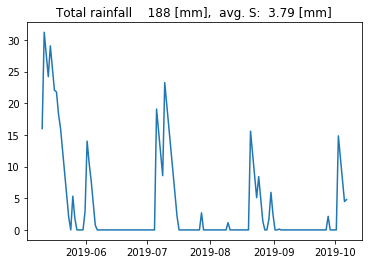

In [13]:
plt.plot(dt,S)
plt.title("Total rainfall {rain:6.0f} [mm],  avg. S:{S:6.2f} [mm]".format(
    rain=sum(R),
    S=S.mean()
))

### Running the ecohydrological model (multiple seasons)

Running the model for multiple seasons requires only a slight modification to how we collect the output. Instead of a single dictionary with the output, we create a list of dictionaries, which each contain output for one simulation. We are also going to include more variables explicitly in Step 2:

```python
planting_date = datetime(year=2018, month=10, day=15)
n_seasons = 100
days_to_maturity = 150
```


Text(0.5,1,'Mar 15 to Aug 12, n=100, S_avg=14.97')

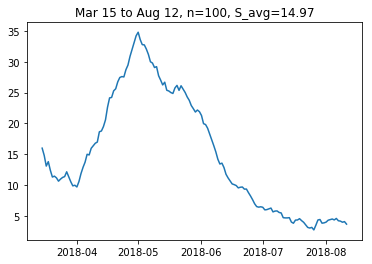

In [14]:
# Step 1. Analyze station rainfall data.
station = 'JACOBSON FARM'
alpha, lambda_by_month, rain_data = analyze_rainfall(station=station)

# Step 2. Simulate n seasons of rainfall
from datetime import timedelta

planting_date = datetime(year=2018, month=3, day=15)
n_seasons = 100
days_to_maturity = 150

R, dt = simulate_rainfall(lambda_by_month, alpha, planting_date=planting_date, n_seasons=n_seasons)

# Step 3. Run the ecohydrological model.
output = []
S = []
dSdt = []
for r in R:
    output = (run_model(r))
    S.append(output['S'])
    dSdt.append(output['dSdt'])

# It's very easy to turn a list of lists into a `DataFrame`
df_S = pd.DataFrame(S)
plt.plot(dt, df_S.mean())
plt.title("{date} to {end}, n={n}, S_avg={s:5.2f}".format(
    date=datetime.strftime(planting_date,"%b %d"),
    end=datetime.strftime(planting_date+timedelta(days=days_to_maturity),"%b %d"),
    n=n_seasons,
    s=df_S.mean().mean()))

## Effect of planting date on average soil water availability

We can use our model to see how planting date alters the average soil water availability during the growing season.

We will use a for loop to iterate across planting dates

```python 
station = 'JACOBSON FARM'
alpha, lambda_by_month, rain_data = analyze_rainfall(station=station)
n_seasons = 100
days_to_maturity = 150

planting_dates = np.arange(datetime(2017,1,1), datetime(2017,12,31), timedelta(weeks=1)).astype(datetime)

S_avg = []
for planting_date in planting_dates:
    R, dt = simulate_rainfall(lambda_by_month, alpha, planting_date=planting_date, n_seasons=n_seasons)

    # Step 3. Run the ecohydrological model.
    output = []
    S = []
    dSdt = []
    for r in R:
        output = (run_model(r))
        S.append(output['S'])
        dSdt.append(output['dSdt'])
    df_S = pd.DataFrame(S)
    S_avg.append(df_S.mean().mean())
```

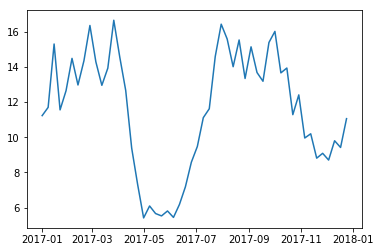

In [15]:
station = 'JACOBSON FARM'
alpha, lambda_by_month, rain_data = analyze_rainfall(station=station)
n_seasons = 100
days_to_maturity = 150

planting_dates = np.arange(datetime(2017,1,1), datetime(2017,12,31), timedelta(weeks=1)).astype(datetime)

S_avg = []
for planting_date in planting_dates:
    R, dt = simulate_rainfall(lambda_by_month, alpha, planting_date=planting_date, n_seasons=n_seasons)

    # Step 3. Run the ecohydrological model.
    output = []
    S = []
    dSdt = []
    for r in R:
        output = (run_model(r))
        S.append(output['S'])
        dSdt.append(output['dSdt'])
    df_S = pd.DataFrame(S)
    S_avg.append(df_S.mean().mean())

plt.plot(planting_dates,S_avg)

It appears that there are two fairly broad periods of moderate water availability, separated by deep valleys of low water availability. Our next question is how do planting date and days to maturity interact. We can examine this by nesting two for loops.

```python
station = 'JACOBSON FARM'
alpha, lambda_by_month, rain_data = analyze_rainfall(station=station)
n_seasons = 100
varieties = [120, 180]

planting_dates = np.arange(datetime(2017,1,1), datetime(2017,12,31), timedelta(weeks=1)).astype(datetime)

S_avg = [[],[]]

for planting_date in planting_dates:
    for i, days_to_maturity in enumerate(varieties): 
        R, dt = simulate_rainfall(
            lambda_by_month, alpha,
            days_to_maturity=days_to_maturity,
            planting_date=planting_date, n_seasons=n_seasons)

        # Step 3. Run the ecohydrological model.
        output = []
        S = []
        dSdt = []
        for r in R:
            output = (run_model(r))
            S.append(output['S'])
            dSdt.append(output['dSdt'])
        df_S = pd.DataFrame(S)
        S_avg[i].append(df_S.mean().mean())
```

Text(0.5,1,'Effect of planting date and variety on soil water availability')

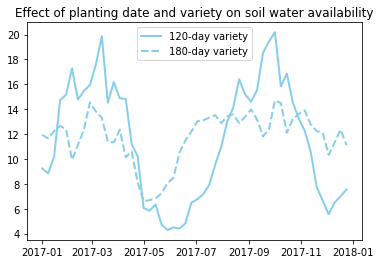

In [16]:
station = 'JACOBSON FARM'
alpha, lambda_by_month, rain_data = analyze_rainfall(station=station)
n_seasons = 100
varieties = [120, 180]

planting_dates = np.arange(datetime(2017,1,1), datetime(2017,12,31), timedelta(weeks=1)).astype(datetime)

S_avg = [[],[]]

for planting_date in planting_dates:
    for i, days_to_maturity in enumerate(varieties): 
        R, dt = simulate_rainfall(
            lambda_by_month, alpha,
            days_to_maturity=days_to_maturity,
            planting_date=planting_date, n_seasons=n_seasons)

        # Step 3. Run the ecohydrological model.
        output = []
        S = []
        dSdt = []
        for r in R:
            output = (run_model(r))
            S.append(output['S'])
            dSdt.append(output['dSdt'])
        df_S = pd.DataFrame(S)
        S_avg[i].append(df_S.mean().mean())

df = pd.DataFrame({
    'x': planting_dates,
    '120-day': S_avg[0],
    '180-day': S_avg[1]
})

plt.plot(
    'x', '120-day', data=df, marker='', color='skyblue',
    label='120-day variety', linewidth=2
)
plt.plot('x', '180-day', data=df, marker='', color='skyblue',
    label='180-day variety', linestyle='dashed', linewidth=2
)
plt.legend()
plt.title('Effect of planting date and variety on soil water availability')

We see that the variety that matures more quickly has a narrow range of success, but higher peaks in terms of seasonal water availability.

## Coefficients of Seasonal Rainfall Variability across Laikipia

Analysis from [Philip Thornton](https://ccafs.cgiar.org/about/people/philip-thornton#.W4H37S2ZPOQ) at CCAFS/CGIAR suggests that there are fairly sharp thresholds in the relationship between rainfall climatology and crop failure. The following two figures demonstrate this relationship from some of his previous work.

![](../assets/crop_failure_vs_rainfall_cv.png)
            
![](../assets/cropping_extent_vs_rainfall_cv.png)


The top panel demonstrates how rainfall CV (on the x-axis) relates to the probability of crop failure in dryland agricultural systems (y-axis). The bottom panel provides the distribution of rainfall values and cropping extent (% area occupied by crops) across Sub-Saharan Africa. Rather than depicting a scatterplot, the varying color represents the density of observations in each portion of the graph's coordinate space.

Based on the upper panel, we can analyze various stations around Laikipia to see how they compare to the CV thresholds.

<div class="alert alert-success">✏️ <strong>DIY Code:</strong> Use our code from Chapter 2 to analyze the simulated CV of growing season rainfall for different stations across Laikpia.</div>

<div class="alert alert-info">💡 <strong>Hint</strong>: You can use our model analyses to determine optimal planting dates for any station. Running the model gives a suite of seasonal rainfall amounts from which you can determin the CV of seasonal rainfall amounts.</div>

In [17]:
# This cell intentionally left blank

## Coupling rainfall variability, water availability, and yield

Our next step will be to develop a relationship between soil water availability and yield. Most annual crops require a minimuim amount of soil moisture to avoid wilting. Furthermore, prolonged periods of wilting/stress are likely to cause complete crop failure. 

We can specify a threshold of water resource scarcity, and/or a maximum duration of water scarcity that would lead to crop failure and use our same analysis framework to examine how our system responds. We don't need to change our model, we only need to analyze our results.

Let's say that for any variety, at least **10 mm** of water is necessary to avoid wilting. For our soil, 10 mm corresponds to a volumetric soil moisture of 5%, which is pretty dry. In addition, let's say that any season with more the 25% of the days are below this threshold leads to crop failure. 

Let's define these two new variables as $S_{wp}=10$, the soil water amount associated with wilting point) and $T_{wp}=0.25*T_{harvest}$, the maximum amount of time at or below wilting point before crops fail.

<div class="alert alert-success">✏️ <strong>DIY Code:</strong> Use the $S_{wp}$ and $T_{wp}$ values to determine the likelihood of crop failure based on planting date.</div>

<div class="alert alert-info">💡 <strong>Hint</strong>: Since we haven't changed the model - only how we interpret the data - you can use the same output we've already generated for our earlier analyses.</div>

In [18]:
# This cell intentionally left blank.